<a href="https://colab.research.google.com/github/Viny2030/HUMAI/blob/main/MecanismosDeAtencion.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Mecanismos de Atención

# Queries, Keys, and Values

Pensemos un poco en las bases de datos. En su forma más simple son colecciones de claves ($k$) y valores ($v$). Por ejemplo, nuestra base de datos $\mathcal{D}$ podría consistir en tuplas \{("Zhang", "Aston"), ("Lipton", "Zachary"), ("Li", "Mu"), (" Smola", "Alex"), ("Hu", "Rachel"), ("Werness", "Brent")\} siendo el apellido la clave y el nombre el valor. Podemos operar en $\mathcal{D}$, por ejemplo con la consulta exacta ($q$) para "Li" que devolvería el valor "Mu". Si ("Li", "Mu") no fuera un registro en $\mathcal{D}$, no habría una respuesta válida. Si también permitiéramos coincidencias aproximadas, recuperaríamos ("Lipton", "Zachary") en su lugar. Sin embargo, este ejemplo bastante simple y trivial nos enseña una serie de cosas útiles:

* Podemos diseñar consultas $q$ que operen en pares ($k$,$v$) de tal manera que sean válidas independientemente del tamaño de la base de datos.
* Una misma consulta puede recibir diferentes respuestas, según el contenido de la base de datos.
* El "código" que se ejecuta para operar en un espacio de estado grande (la base de datos) puede ser bastante simple (por ejemplo, coincidencia exacta, coincidencia aproximada, top-$k$).
* No es necesario comprimir ni simplificar la base de datos para que las operaciones sean efectivas.

Claramente no habríamos introducido aquí una base de datos simple si no fuera con el propósito de explicar el aprendizaje profundo. De hecho, esto conduce a uno de los conceptos más interesantes introducidos en el aprendizaje profundo en la última década: el *mecanismo de atención*. Por ahora, simplemente considere lo siguiente: sea $\mathcal{D} \stackrel{\textrm{def}}{=} \{(\mathbf{k}_1, \mathbf{v}_1), \ldots (\mathbf{k}_m, \mathbf{v}_m)\}$ una base de datos de $m$ tuplas de *claves* y *valores*. Además, denota por $\mathbf{q}$ una *consulta*. Entonces podemos definir la *atención* sobre $\mathcal{D}$ como

$$\textrm{Attention}(\mathbf{q}, \mathcal{D}) \stackrel{\textrm{def}}{=} \sum_{i=1}^m \alpha(\mathbf{q}, \mathbf{k}_i) \mathbf{v}_i,$$


donde $\alpha(\mathbf{q}, \mathbf{k}_i) \in \mathbb{R}$ ($i = 1, \ldots, m$) son pesos de atención escalares. La operación en sí se suele denominar *agrupación de atención*. El nombre *atención* deriva del hecho de que la operación presta especial atención a los términos para los cuales el peso $\alpha$ es significativo (es decir, grande). Como tal, la atención sobre $\mathcal{D}$ genera una combinación lineal de valores contenidos en la base de datos. De hecho, esto contiene el ejemplo anterior como un caso especial en el que todos los pesos menos uno son cero. Tenemos una serie de casos especiales:

* Los pesos $\alpha(\mathbf{q}, \mathbf{k}_i)$ forman una combinación convexa, es decir, $\sum_i \alpha(\mathbf{q}, \mathbf{k}_i) = 1$ y $\alpha(\mathbf{q}, \mathbf{k}_i) \geq 0$ para todos los $i$. Esta es la configuración más común en el aprendizaje profundo.
* Exactamente uno de los pesos $\alpha(\mathbf{q}, \mathbf{k}_i)$ es $1$, mientras que todos los demás son $0$. Esto es similar a una consulta de base de datos tradicional.
* Todos los pesos son iguales, es decir, $\alpha(\mathbf{q}, \mathbf{k}_i) = \frac{1}{m}$ para todos los $i$. Esto equivale a promediar toda la base de datos, también llamado average pooling en aprendizaje profundo.

Una estrategia común para garantizar que los pesos sumen $1$ es normalizarlos mediante

$$\alpha(\mathbf{q}, \mathbf{k}_i) = \frac{\alpha(\mathbf{q}, \mathbf{k}_i)}{{\sum_j} \alpha(\mathbf{q}, \mathbf{k}_j)}.$$

En particular, para garantizar que las ponderaciones tampoco sean negativas, se puede recurrir a la exponenciación. Esto significa que ahora podemos elegir *cualquier* función $a(\mathbf{q}, \mathbf{k})$ y luego aplicarle la operación softmax utilizada para los modelos multinomiales mediante
$$\alpha(\mathbf{q}, \mathbf{k}_i) = \frac{\exp(a(\mathbf{q}, \mathbf{k}_i))}{\sum_j \exp(a(\mathbf{q}, \mathbf{k}_j))}. $$

Esta operación está disponible en todos los marcos de aprendizaje profundo. Es diferenciable y su gradiente nunca desaparece, todas las cuales son propiedades deseables en un modelo.

![The attention mechanism computes a linear combination over values $\mathbf{v}_\mathit{i}$ via attention pooling,
where weights are derived according to the compatibility between a query $\mathbf{q}$ and keys $\mathbf{k}_\mathit{i}$.](https://imgur.com/aFaB03A.png)

Lo que es bastante notable es que el "código" real para ejecutar en el conjunto de claves y valores, es decir, la consulta, puede ser bastante conciso, aunque el espacio para operar es significativo. Esta es una propiedad deseable para una capa de red, ya que no requiere demasiados parámetros para aprender. Igual de conveniente es el hecho de que la atención puede operar en bases de datos arbitrariamente grandes sin la necesidad de cambiar la forma en que se realiza la operación de agrupación de atención.


## Visualización

Uno de los beneficios del mecanismo de atención es que puede ser bastante intuitivo, particularmente cuando los pesos no son negativos y suman $1$. En este caso podríamos *interpretar* pesos grandes como una forma para que el modelo seleccione componentes de relevancia. Si bien esta es una buena intuición, es importante recordar que es sólo eso, una *intuición*. De todos modos, es posible que queramos visualizar su efecto en el conjunto de claves dado al aplicar una variedad de consultas diferentes. Esta función será útil más adelante.

Así definimos la función `show_heatmaps`. Tenga en cuenta que no toma una matriz (de pesos de atención) como entrada, sino un tensor con cuatro ejes, lo que permite una variedad de consultas y pesos diferentes. En consecuencia, las "matrices" de entrada tienen la forma (número de filas para mostrar, número de columnas para mostrar, número de consultas, número de claves). Esto será útil más adelante cuando queramos visualizar el funcionamiento del diseño de Transformers.

In [1]:
import torch
import sys
from matplotlib import pyplot as plt
from matplotlib_inline import backend_inline

def show_heatmaps(matrices, xlabel, ylabel, titles=None, figsize=(2.5, 2.5),
                  cmap='Reds'):
    """Show heatmaps of matrices."""
    backend_inline.set_matplotlib_formats('svg')
    num_rows, num_cols, _, _ = matrices.shape
    fig, axes = plt.subplots(num_rows, num_cols, figsize=figsize,
                                 sharex=True, sharey=True, squeeze=False)
    for i, (row_axes, row_matrices) in enumerate(zip(axes, matrices)):
        for j, (ax, matrix) in enumerate(zip(row_axes, row_matrices)):
            pcm = ax.imshow(matrix.detach().numpy(), cmap=cmap)
            if i == num_rows - 1:
                ax.set_xlabel(xlabel)
            if j == 0:
                ax.set_ylabel(ylabel)
            if titles:
                ax.set_title(titles[j])
    fig.colorbar(pcm, ax=axes, shrink=0.6);

Como comprobación rápida de cordura, visualicemos la matriz de identidad, que representa un caso en el que el peso de atención es $1$ solo cuando la consulta y la clave son las mismas.


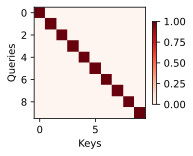

In [3]:
attention_weights = torch.eye(10).reshape((1, 1, 10, 10))  ## matriz identidad ilustrando la base de datos
show_heatmaps(attention_weights, xlabel='Keys', ylabel='Queries')

# Atención de Producto Punto
En la sección anterior dijimos que podíamos elegir *cualquier* función $a(\mathbf{q}, \mathbf{k})$ y luego aplicarle la operación softmax  para asegurar que los pesos de atención se comportaran como distribuciones de probabilidad. En esta sección vamos a algunos ejemplos típicos para $a(\mathbf{q}, \mathbf{k})$ conocidas como **`Funciones de Puntuación de Atención`** (Attention Scoring Functions).  
![Computing the output of attention pooling as a weighted average of values, where weights are computed with the attention scoring function $\mathit{a}$ and the softmax operation.](https://imgur.com/2E4Ph1O.png)



In [4]:
import math
import torch
from torch import nn
#from d2l import torch as d2l

Supongamos que todos los elementos de la consulta $\mathbf{q} \in \mathbb{R}^d$ y la clave $\mathbf{k}_i \in \mathbb{R}^d$ son independientes y se dibujan aleatoriamente de forma idéntica. variables con media cero y varianza unitaria. El producto escalar entre ambos vectores tiene media cero y una varianza de $d$. Para garantizar que la varianza del producto escalar siga siendo $1$ independientemente de la longitud del vector, utilizamos la función de puntuación *atención del producto escalar*. Es decir, reescalamos el producto escalar en $1/\sqrt{d}$. Llegamos así a la primera función de atención comúnmente utilizada que se utiliza

$$ a(\mathbf{q}, \mathbf{k}_i) = \mathbf{q}^\top \mathbf{k}_i / \sqrt{d}.$$


Tenga en cuenta que los pesos de atención $\alpha$ aún necesitan normalizarse. Podemos simplificar esto aún más mediante

$$\alpha(\mathbf{q}, \mathbf{k}_i) = \mathrm{softmax}(a(\mathbf{q}, \mathbf{k}_i)) = \frac{\exp(\mathbf{q}^\top \mathbf{k}_i / \sqrt{d})}{\sum_{j=1} \exp(\mathbf{q}^\top \mathbf{k}_j / \sqrt{d})}.$$

Resulta que todos los mecanismos de atención populares utilizan softmax, por lo que nos limitaremos a eso en el resto de este capítulo.



## Funciones Útiles

Necesitamos algunas funciones para que el mecanismo de atención sea eficiente de implementar. Esto incluye herramientas para manejar cadenas de longitudes variables (comunes para el procesamiento del lenguaje natural) y herramientas para una evaluación eficiente en minibatches (multiplicación de matrices por lotes).




### Operación Softmax enmascarada

Una de las aplicaciones más populares del mecanismo de atención son los modelos que procesan secuencias. Por tanto, necesitamos poder tratar con secuencias de diferentes longitudes. En algunos casos, dichas secuencias pueden terminar en el mismo minibatch, lo que requiere rellenar con tokens ficticios para secuencias más cortas. Estas fichas especiales no tienen significado. Por ejemplo, supongamos que tenemos las siguientes tres oraciones:

```
Dive  into  Deep    Learning
Learn to    code    <blank>
Hello world <blank> <blank>
```

Como no queremos que nuestro modelo preste atención a los espacios en blanco, simplemente necesitamos limitar $\sum_{i=1}^n \alpha(\mathbf{q}, \mathbf{k}_i) \mathbf{v}_i$ a $ \sum_{i=1}^l \alpha(\mathbf{q}, \mathbf{k}_i) \mathbf{v}_i$ donde $l \leq n$, es el tamaño real de la oración. Dado que es un problema tan común, tiene un nombre: **`operación softmax enmascarada`**.

Implementémoslo. En realidad, la implementación hace un ligero truco al establecer los valores de $\mathbf{v}_i$, para $i > l$, en cero. Además, establece los pesos de atención en un número negativo grande, como $-10^{6}$, para que su contribución a los gradientes y valores desaparezca en la práctica. Esto se hace porque los núcleos y operadores de álgebra lineal están muy optimizados para las GPU y es más rápido desperdiciar un poco el cálculo que tener código con declaraciones condicionales (if then else)

In [6]:
def masked_softmax(X, valid_lens):
    """Perform softmax operation by masking elements on the last axis."""
    # X: 3D tensor, valid_lens: 1D or 2D tensor
    def _sequence_mask(X, valid_len, value=0):  ## mascara con la longitud maxima
        maxlen = X.size(1)
        mask = torch.arange((maxlen), dtype=torch.float32,
                            device=X.device)[None, :] < valid_len[:, None]
        X[~mask] = value
        return X

    if valid_lens is None:
        return nn.functional.softmax(X, dim=-1)
    else:
        shape = X.shape
        if valid_lens.dim() == 1:
            valid_lens = torch.repeat_interleave(valid_lens, shape[1])
        else:
            valid_lens = valid_lens.reshape(-1)
        # On the last axis, replace masked elements with a very large negative
        # value, whose exponentiation outputs 0
        X = _sequence_mask(X.reshape(-1, shape[-1]), valid_lens, value=-1e6)
        return nn.functional.softmax(X.reshape(shape), dim=-1)

Para ilustrar cómo funciona esta función, considere un minilote de dos ejemplos de tamaño $2 \times 4$, donde sus longitudes válidas son $2$ y $3$, respectivamente. Como resultado de la operación softmax enmascarada, los valores más allá de las longitudes válidas para cada par de vectores se enmascaran como cero.

In [8]:
masked_softmax(torch.rand(2, 2, 4), torch.tensor([2, 3]))  ## multiplicacion de varias matrices por lote trato al tensor como lote de matrices

tensor([[[0.5680, 0.4320, 0.0000, 0.0000],
         [0.6496, 0.3504, 0.0000, 0.0000]],

        [[0.3633, 0.3021, 0.3346, 0.0000],
         [0.3997, 0.2979, 0.3024, 0.0000]]])

Si necesitamos un control más detallado para especificar la longitud válida para cada uno de los dos vectores de cada ejemplo, simplemente usamos un tensor bidimensional de longitudes válidas. Esto produce:


In [9]:
masked_softmax(torch.rand(2, 2, 4), torch.tensor([[1, 3], [2, 4]]))

tensor([[[1.0000, 0.0000, 0.0000, 0.0000],
         [0.2868, 0.2686, 0.4446, 0.0000]],

        [[0.4915, 0.5085, 0.0000, 0.0000],
         [0.2301, 0.2288, 0.2640, 0.2770]]])

### Multiplicación de matrices por lotes
Otra operación comúnmente utilizada es multiplicar lotes de matrices entre sí. Esto resulta útil cuando tenemos minilotes de consultas, claves y valores. Más específicamente, supongamos que

$$\mathbf{Q} = [\mathbf{Q}_1, \mathbf{Q}_2, \ldots, \mathbf{Q}_n]  \in \mathbb{R}^{n \times a \times b}, \\
    \mathbf{K} = [\mathbf{K}_1, \mathbf{K}_2, \ldots, \mathbf{K}_n]  \in \mathbb{R}^{n \times b \times c}.
$$

Luego, la multiplicación de matrices por lotes (BMM) calcula el producto elemento a elemento

$$\textrm{BMM}(\mathbf{Q}, \mathbf{K}) = [\mathbf{Q}_1 \mathbf{K}_1, \mathbf{Q}_2 \mathbf{K}_2, \ldots, \mathbf{Q}_n \mathbf{K}_n] \in \mathbb{R}^{n \times a \times c}.$$


Veamos cómo se hace esto en PyTorch.


In [12]:
Q = torch.ones((2, 3, 4))
K = torch.ones((2, 4, 6))
torch.bmm(K, Q).shape  ## no funciona por tamaño de matriz

RuntimeError: Expected size for first two dimensions of batch2 tensor to be: [2, 6] but got: [2, 3].

In [11]:
Q = torch.ones((2, 3, 4))
K = torch.ones((2, 4, 6))
torch.bmm(Q, K).shape  ## funcion bmm batch multiplication ojo matrices de 3 x 4 y 4 x 6

torch.Size([2, 3, 6])

## Implementación como Capa

Volvamos a la atención del producto  introducida.
En general, requiere que tanto la consulta como la clave tengan la misma longitud de vector, digamos $d$, aunque esto se puede solucionar fácilmente reemplazando $\mathbf{q}^\top \mathbf{k}$ con $\mathbf{q}^\top \mathbf{M} \mathbf{k}$ donde $\mathbf{M}$ es una matriz adecuadamente elegida para traducir entre ambos espacios. Por ahora supongamos que las dimensiones coinciden.

En la práctica, a menudo pensamos en minilotes para lograr eficiencia, como calcular la atención para $n$ consultas y $m$ pares clave-valor.
donde las consultas y las claves tienen una longitud $d$ y los valores tienen una longitud $v$. La atención del producto escalar escalado de consultas $\mathbf Q\in\mathbb R^{n\times d}$, claves $\mathbf K\in\mathbb R^{m\times d}$ y valores $\mathbf V \in\mathbb R^{m\times v}$ por lo tanto se puede escribir como

$$ \mathrm{softmax}\left(\frac{\mathbf Q \mathbf K^\top }{\sqrt{d}}\right) \mathbf V \in \mathbb{R}^{n\times v} .$$


Tenga en cuenta que al aplicar esto a un minibatch, necesitamos la multiplicación de matrices por lotes introducida anteriormente. En la siguiente implementación de la atención del producto escalado, utilizamos dropout para la regularización del modelo.

In [13]:
class DotProductAttention(nn.Module):
    """Scaled dot product attention."""
    def __init__(self, dropout):
        super().__init__()
        self.dropout = nn.Dropout(dropout)

    # Shape of queries: (batch_size, no. of queries, d)
    # Shape of keys: (batch_size, no. of key-value pairs, d)
    # Shape of values: (batch_size, no. of key-value pairs, value dimension)
    # Shape of valid_lens: (batch_size,) or (batch_size, no. of queries)
    def forward(self, queries, keys, values, valid_lens=None):
        d = queries.shape[-1]
        # Swap the last two dimensions of keys with keys.transpose(1, 2)
        scores = torch.bmm(queries, keys.transpose(1, 2)) / math.sqrt(d)
        print(f"scores shape: {scores.shape}")
        self.attention_weights = masked_softmax(scores, valid_lens)
        return torch.bmm(self.dropout(self.attention_weights), values)

Para ilustrar cómo funciona la clase `DotProductAttention`, asumimos que tenemos un tamaño de minibatch de $2$, un total de $10$ claves y valores, y que la dimensionalidad de los valores es $4$. Por último, asumimos que la longitud válida por observación es $2$ y $6$ respectivamente. Dado eso, esperamos que la salida sea un tensor $2 \times 1 \times 4$, es decir, una fila por ejemplo del minibatch.


## en un problema de nlp se usan las palabras pasadas y los valores son las palabras pasadas

In [14]:
queries = torch.normal(0, 1, (2, 1, 2))
keys = torch.normal(0, 1, (2, 10, 2))
values = torch.normal(0, 1, (2, 10, 4))
valid_lens = torch.tensor([2, 6])

attention = DotProductAttention(dropout=0.5)
attention.eval()
attention(queries, keys, values, valid_lens)

scores shape: torch.Size([2, 1, 10])


tensor([[[-2.1834, -0.3048,  0.9834, -0.4412]],

        [[-0.0543, -0.2113,  0.2842, -0.5106]]])

Vamos a comprobar si los pesos de atención realmente desaparecen para cualquier cosa más allá de la segunda y sexta columna respectivamente (debido a establecer la longitud válida en $2$ y $6$).


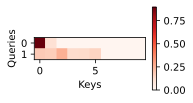

In [15]:
show_heatmaps(attention.attention_weights.reshape((1, 1, 2, 10)),
                  xlabel='Keys', ylabel='Queries')

## el producto punto necesita que las consultas y las query tengan la mismas claves

# Atención aditiva

Cuando las consultas $\mathbf{q}$ y las claves $\mathbf{k}$ son vectores de diferente dimensión, podemos usar una matriz para abordar la discrepancia mediante $\mathbf{q}^\top \mathbf{M} \mathbf{k}$, o podemos usar atención aditiva como función de puntuación. Otro beneficio es que, como su nombre indica, la atención es aditiva. Esto puede generar algunos ahorros computacionales menores. Dada una consulta $\mathbf{q} \in \mathbb{R}^q$ y una clave $\mathbf{k} \in \mathbb{R}^k$, la función de puntuación de *atención aditiva*  está dado por

$$a(\mathbf q, \mathbf k) = \mathbf w_v^\top \textrm{tanh}(\mathbf W_q\mathbf q + \mathbf W_k \mathbf k) \in \mathbb{R},$$

donde $\mathbf W_q\in\mathbb R^{h\times q}$, $\mathbf W_k\in\mathbb R^{h\times k}$ y $\mathbf w_v\in\mathbb R^{h }$ son los parámetros que se pueden aprender. Luego, este término se introduce en un softmax para garantizar tanto la no negatividad como la normalización. Usando $\tanh$ como función de activación y deshabilitando los términos de sesgo, implementamos la atención aditiva de la siguiente manera:

In [16]:
class AdditiveAttention(nn.Module):
    """Additive attention."""
    def __init__(self, num_hiddens, dropout, **kwargs):
        super(AdditiveAttention, self).__init__(**kwargs)
        self.W_k = nn.LazyLinear(num_hiddens, bias=False)
        self.W_q = nn.LazyLinear(num_hiddens, bias=False)
        self.w_v = nn.LazyLinear(1, bias=False)
        self.dropout = nn.Dropout(dropout)

    def forward(self, queries, keys, values, valid_lens):
        queries, keys = self.W_q(queries), self.W_k(keys)

        # After dimension expansion,
        # shape of queries: (batch_size, no. of queries, 1, num_hiddens) and
        # shape of keys: (batch_size, 1, no. of key-value pairs, num_hiddens).
        # Sum them up with broadcasting
        features = queries.unsqueeze(2) + keys.unsqueeze(1)
        features = torch.tanh(features)
        # There is only one output of self.w_v, so we remove the last
        # one-dimensional entry from the shape.
        # Shape of scores: (batch_size, no. of queries, no. of key-value pairs)
        scores = self.w_v(features).squeeze(-1)
        self.attention_weights = masked_softmax(scores, valid_lens)
        # Shape of values: (batch_size, no. of key-value pairs, value
        # dimension)
        return torch.bmm(self.dropout(self.attention_weights), values)

Veamos cómo funciona "AdditiveAttention". En nuestro ejemplo de juguete, elegimos consultas, claves y valores de tamaño$(2, 1, 20)$, $(2, 10, 2)$ y $(2, 10, 4)$, respectivamente. Esto es idéntico a nuestra elección para `DotProductAttention`, excepto que ahora las consultas tienen una dimensión de $20$. Del mismo modo, elegimos $(2, 6)$ como las longitudes válidas para las secuencias del minibatch.


In [19]:
queries = torch.normal(0, 1, (2, 1, 20))

attention = AdditiveAttention(num_hiddens=8, dropout=0.1)
attention.eval()
attention(queries, keys, values, valid_lens)  ## la salida es un vector de 4 dimensiones

tensor([[[-1.4817, -0.5109,  0.8008, -0.3161]],

        [[ 0.0222, -0.2062,  0.3121, -0.5338]]], grad_fn=<BmmBackward0>)

Al revisar la función de atención vemos un comportamiento cualitativamente bastante similar al de `DotProductAttention`. Es decir, sólo los términos dentro de la longitud válida elegida $(2, 6)$ son distintos de cero.


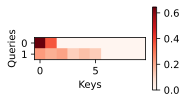

In [20]:
show_heatmaps(attention.attention_weights.reshape((1, 1, 2, 10)),  ## en base a los pesos estan guardados como atributo
                  xlabel='Keys', ylabel='Queries')